In [49]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

Integrantes: 

* Daniel Julián Rojas Cruz
* Johan Tanta Villanueva

# Redes Bayesianas - Inteligencia Artificial


Se presenta la implementación de la función count que retorna el número de filas que satisfacen las igualdades


In [50]:
hide_toggle(True)

In [51]:
import pandas as pd
import numpy as np
import math
import random 
import copy


def count(dataframe, index_list, values_list):
    resultado = dataframe
    for i in range(len(index_list)):
        index = index_list[i]
        value = values_list[i]

    #filtrar la columna 
        resultado = resultado[resultado[index] == value]
    c =resultado.shape[0]
    return c



## Objetivo 1
El objetivo 1 consiste en estimar la marginal para una variable en consulta a partir de un dataset

### Implementación del Objetivo 1


In [52]:
hide_toggle(True)

In [53]:
# Esta función recive el nombre del archivo CSV y devuelve un dataframe de Pandas
def leer_dataset(nom_archivo):
    return pd.read_csv(nom_archivo)




def cardinalidad(df, X):
    return df[X].unique()

# Esta funcióm devuelve un reporte del factor que contiene a la variable X
def estimar_marginal(df,X, alpha):
    card = cardinalidad(df,X) # lista de valores únicos
    
    nfilas = df.shape[0]
    
    probList = []
    for valor in card:
        m = count(df,[X],[valor])
        p = (m + alpha)/(nfilas + len(card)*alpha)
        probList.append(p)
    probColName = "P"
    columns = {X:card, probColName: probList}
    
    return pd.DataFrame(columns)

def estimar_conjunta(df,variables,alpha):
    card = {}
    nfilas = 1
    
    ## filas en el df
    n = df.shape[0]
    
    for var in variables:
        card[var] = cardinalidad(df,var)
        nfilas = nfilas*len(card[var])
        
    columns = {}
    
    n_rep = 1
    for var, cardinal in card.items():
        columns[var] = [ cardinal[int(i/n_rep)%len(cardinal)] for i in range(nfilas) ]
        n_rep = n_rep * len(cardinal)

    result = pd.DataFrame(columns)
    
    probList = []
    
    #Iteramos por cada fila del dataframe y hallamos la probabilidad condicional
    for i in result.index:
        valores = []
        for var in variables:
            valores.append(result[var][i])
      
        n_intersection = count(df,variables,valores)
    
        p = (n_intersection + alpha)/ ( n + n_rep*alpha)
        
        probList.append(p)
    
    result['P'] = probList
    return result

## Objetivo 2
El objetivo 2 consiste en estimar la condicional para un par o más variables en consulta a partir del dataset previo

### Implementación del Objetivo 2


In [54]:
hide_toggle(True)

In [55]:
def estimar_condicional(df, X, Y, alpha):
    # hallar el número total de filas 
    nFilasResult = 1
    nfilas = df.shape[0]
    cardTarget = cardinalidad(df,X)
    nFilasResult = nFilasResult*len(cardTarget)
    
    cardY = {}
    for var in Y:
        cardY[var] = cardinalidad(df,var)
        nFilasResult = nFilasResult*len(cardY[var])
    
    columns = {}
    
    n_rep = 1
    
    colTarget = [cardTarget[i%len(cardTarget)] for i in range(nFilasResult)]
    
    columns[X] = colTarget
    n_rep = n_rep * len(cardTarget)
    
    for var, card in cardY.items():
        columns[var] = [ card[int(i/n_rep)%len(card)] for i in range(nFilasResult) ]
        
        n_rep = n_rep * len(card)

    
    result = pd.DataFrame(columns)
    probList = []
    
    prodCardY = 1
    for var in Y:
        prodCardY = prodCardY* len(cardY[var])
        
    #Iteramos por cada fila del dataframe y hallamos la probabilidad condicional
    for i in result.index:
        valTarget = result[X][i]
    
        valPadres = []
        for var in Y:
            valPadres.append(result[var][i])
      
        totalVar = [i for i in Y]
        totalVar.append(X)
        totalVal = valPadres
        totalVal.append(valTarget)
        
        
        prob_X_Y = (count(df,totalVar,totalVal) + alpha) / (nfilas + prodCardY*len(cardTarget)*alpha) 
        
        prob_Y = (count(df,Y,valPadres) + alpha) / (nfilas + prodCardY*alpha)
        p = prob_X_Y/prob_Y
        probList.append(p)
    # normalizamos las probabilidades
    
    for i in range(int (nFilasResult / len(cardTarget))):
        suma = 0
        for j in range(len(cardTarget)):
            suma = suma + probList[i*len(cardTarget) + j]
        
        for j in range(len(cardTarget)):
            probList[i*len(cardTarget) + j] = probList[i*len(cardTarget) + j] / suma 
    
    result['P'] = probList
    return result

df = leer_dataset("weather.csv")
cond = estimar_condicional(df,'outlook', ['windy','play'],1)
cond

,outlook,windy,play,P
0,overcast,False,yes,0.333333
1,rainy,False,yes,0.444444
2,sunny,False,yes,0.222222
3,overcast,True,yes,0.500000
4,rainy,True,yes,0.166667
5,sunny,True,yes,0.333333
6,overcast,False,no,0.200000
7,rainy,False,no,0.200000
8,sunny,False,no,0.600000
9,overcast,True,no,0.166667


# Preprocesamiento

In [56]:
hide_toggle(True)

In [57]:

class Preprocessor:
    def __init__(self, df ,alpha):
        self.variables = self.get_vars(df)
        self.alpha = alpha
        self.df = df
        self.card = self.get_cards(df)
        self.marg_cond = self.preprocess(df)
        self.conj = self.calcular_conjunta(df)
        self.instancias = len(df.index)
    
    def get_cards(self, df):
        nodes = self.variables
        card = {}
        for value in nodes:
            card[value] = df[value].unique()
        return card
    
    def get_vars(self,df):
        variables = []
        for i in df:
            variables.append(i)
        
        return variables
    
    def calcular_conjunta(self,df):
        prob = {}
        
        #calcular las conjunta de cada par de variables diferentes
        for variable_1 in self.variables:
            for variable_2 in self.variables:
                if (variable_1 == variable_2):
                    continue
                prob[tuple([variable_1, variable_2])] = estimar_conjunta(df,[variable_1,variable_2], self.alpha)
        return prob
    
    #preprocesa las marginales y las condicionales para cada para de variables 
    def preprocess(self,df):
        prob = {}
        
        #calcular las marginales de todas la variables
        for variable in self.variables:
            prob[tuple(variable)] = estimar_marginal(df,variable,self.alpha)
        
        #calcular las condicionales de cada par de variables diferentes
        for variable_1 in self.variables:
            for variable_2 in self.variables:
                if (variable_1 == variable_2):
                    continue
                prob[tuple([variable_1, variable_2])] = estimar_condicional(df,variable_1, [variable_2], self.alpha)
        return prob
    
    
    def get_preprocess_marginal(self, variable, valor):
        resultado = self.marg_cond[(variable,)]
        resultado = resultado[resultado[variable]==valor]
        return list(resultado['P'])[0]
    
    def get_preprocess_conjunta(self, variables, valores):
        resultado = self.conj[variables]
        for i in range(2):
            index = variables[i]
            value = valores[i]
            #filtrar la columna 
            resultado = resultado[resultado[index] == value]
            
        return list(resultado['P'])[0]
    
    def get_preprocess_condicional(self, factor, valores):
        resultado = self.marg_cond[factor]
        for i in range(2):
            index = factor[i]
            value = valores[i]
            #filtrar la columna 
            resultado = resultado[resultado[index] == value]
        return list(resultado['P'])[0]
    


# Clase Red Bayesiana

## Implementación

In [58]:
hide_toggle(True)

In [59]:


def get_parents(grafo):
    
    result = {}
    
    for node, list_adyacentes in grafo.items():
        if node not in result:
            result[node] = []
        
        if (len(list_adyacentes) > 0):  
            for child in list_adyacentes:
                if child not in result:
                    result[child] = [node]
                else:
                    result[child].append(node)
                
    
    return result


class Red_Bayesiana:
    def __init__(self, df, grafo, alpha, preprocessor = None):
        self.alpha = alpha
        self.estructura = grafo
        self.parents = get_parents(self.estructura)
        self.factores = self.generate(df)
        self.card = self.get_cards(df)
        self.preprocessor = preprocessor
        
    
    def get_cards(self, df):
        nodes = self.estructura.keys()
        card = {}
        for value in nodes:
            card[value] = df[value].unique()
        return card
    
    def generate(self, df):
        factores = {}
        parents = self.parents
        for child, parent_list in parents.items():
            if (len(parent_list) == 0):
                factores[tuple(child)] = estimar_marginal(df,child, self.alpha)
            else:
                key = parent_list.copy()
                key.insert(0, child)
                key = tuple(key)
                factores[key] = estimar_condicional(df,child, parent_list, self.alpha)
        return factores
    
    def printFactores(self):
        print("Factores del grafo")
        for key, df in self.factores.items():
            
            if (len(key)==1):
                print ("P(" + key[0] + ")", end=" ")
            else:
                s = None
                for i in range(len(key)):
                    if (i==0):
                        s = "P(" + key[0] + "|"
                    elif(i == len(key) - 1):
                        s = s + key[i] + ")"
                    else:
                        s = s + key[i] + ","
                print (s, end=" ")
  
        
    
    def get_scope(self, variable):
        # lista de factores
        factores = []
        for factor in self.factores.keys():
            if(variable in factor):
                factores.append(factor)
        return factores
    
    def get_all_ancestor(self, current, current_parents, amount_of_ancestors, visited):
        visited[current] = True
        for parent in current_parents:
            if(not visited[parent]):
                self.get_all_ancestor(parent, self.parents[parent], amount_of_ancestors, visited)
            amount_of_ancestors[current] = amount_of_ancestors[current] + amount_of_ancestors[parent] + 1
        
    
    def get_hidden_variables(self, consulta, evidencia):
        nodes = self.estructura.keys()
        amount_of_ancestors = {}
        visited = {}
        
        for node in nodes:
            visited[node] = False
            amount_of_ancestors[node] = 0
        
        for node in nodes:
            if(not visited[node]):
                self.get_all_ancestor(node, self.parents[node], amount_of_ancestors, visited)
        
        hidden_variables = []
        for variable in nodes:
            if ((variable not in evidencia) and variable != consulta):
                hidden_variables.append([variable, amount_of_ancestors[variable]])
        
        hidden_variables = sorted(hidden_variables, key=lambda item: item[1])
        
        Z = []
        for i in hidden_variables:
            Z.append(i[0])
        return Z
    
    
    
    def estimar_marginal(self, factor, valores):
     
        assert len(valores) == 1, "Marginal solo acepta un valor"
        resultado = self.factores[factor]
        resultado = resultado[resultado[factor[0]]==valores[0]]
        return list(resultado['P'])[0]
    
    def estimar_condicional(self, factor, valores):
        resultado = self.factores[factor]
        for i in range(len(factor)):
            index = factor[i]
            value = valores[i]
            #filtrar la columna 
            resultado = resultado[resultado[index] == value]
        return list(resultado['P'])[0]

        

## Inferencia


### Implementación de la función inferencia


In [60]:
hide_toggle(True)

In [61]:
def inferencia(clase, e_variables , e_values ,df, red_bayesiana):
    
    var_val = {}
    
    for i in range(len(e_variables)):
        var_val[e_variables[i]] = e_values[i]
    
    # retorna un diccionario con llaves los nodos y valores 
    parentsList = red_bayesiana.parents
    
    card = cardinalidad(df, clase)
    
    list_prob = []
    
    for valor in card:
        p = 1
        var_val[clase] = valor
        for var, parents in parentsList.items():
            if (len(parents) == 0):
                p = p * red_bayesiana.estimar_marginal((var,),[var_val[var]] )
             
            else:
                
                values = [var_val[var]]
                
                for parent in parentsList[var]:
                    values.append(var_val[parent])
                
            
                key = parentsList[var].copy()
                key.insert(0,var)
                key = tuple(key)
                p = p * red_bayesiana.estimar_condicional(key,values)
      
        list_prob.append(p)
    
    columns = {}
    
    columns[clase] = card
    columns['P'] = list_prob
    
    return pd.DataFrame(columns)


df_train = leer_dataset("training_dataset1.csv")
preprocess = Preprocessor(df_train,1.0)

estructura = {'A':['C'],'C': ['B'], 'B':[]}


red = Red_Bayesiana(df_train,estructura, 1.0, preprocess)

inferencia('C',['A','B'],[2,1], df_train, red)


,C,P
0,0,0.105495
1,1,0.087912


# Inferencia con variables ocultas

## Implementación

In [62]:
hide_toggle(True)

In [63]:

def get_scope(factores, variable):
    factores_with_variable = []
    factores_without_variable = []
    for factor in factores:
        if(variable in factor):
            factores_with_variable.append(factor)
        else:
            factores_without_variable.append(factor)
    return (factores_with_variable, factores_without_variable)

def get_vars(phi_prima):
    involved = []
  
    for element in phi_prima:
        for value in element:
            if(value not in involved):
                involved.append(value)
  
    return involved

def sum_product_eliminate_var(factores, variable_to_eliminate, consulta, valor_consulta, evidencia, valor_evidencia , red_bayesiana ):
    # factores que se van a factorizar
    
    phi_prima, phi_prima_prima = get_scope(factores,variable_to_eliminate)
      
  
    # lista de variables involucradas en phi_prima
    variables_in_scope = get_vars(phi_prima)

    #diccionario: llave -> variable , valor -> lista de cardinalidad
    
    var_to_values = {}
    
    for var in variables_in_scope:
        if (var != consulta and (var not in evidencia)):
            var_to_values[var] = red_bayesiana.card[var]
    var_to_values[consulta] = [valor_consulta]
    
    for i in range(len(evidencia)):
        var_to_values[evidencia[i]] = [valor_evidencia[i]]
    

 
    
    # llave: variable , valor --> indice en una n_upla
    var_to_index = {}

    #total number of posibilites
    n =  1
    for var, val in var_to_values.items():
        n = n*len(val)
  
    posibilidades =  []
    for i in range(n):
        posibilidades.append([])
    #
    groups = 1
    
    
    pos = 0
    for var in variables_in_scope:
        var_to_index[var] = pos
        pos = pos + 1
        values = var_to_values[var]
        m = len(values)
        groups = groups*m
        rep = int(n/groups)
        for i in range(groups):
            for j in range(rep):
                posibilidades[i*rep + j].extend([values[i%m]])
  # factores que quedan
  
    p = 0 
  # iterar entre todas las posibilidades
    for n_upla in posibilidades:
    
        p_local = 1
        for dist  in phi_prima:
            var = dist[0]
            cond = dist[1:]
            
            

            # hallar los valores que tomas las variables en la distribuiciones
            if (len(cond) == 0):
                p_marginal = red_bayesiana.estimar_marginal(dist,[n_upla[var_to_index[var]]])
                p_local = p_local*p_marginal
            else:
                valores = []
                for var in dist:
                    index = var_to_index[var]
                    valores.append(n_upla[index])
                
             
                p_condicional = red_bayesiana.estimar_condicional(dist, valores)
              
                p_local = p_local*p_condicional
        p = p + p_local
  # sumatoria de los valores en los factores dentro del get_scope

    return [phi_prima_prima, p]

def sum_product(factores, consulta, valor_consulta, evidencia, valor_evidencia, red_bayesiana):
    
    var_to_val = {}
    for i in range(len(evidencia)):
        var_to_val[evidencia[i]] = valor_evidencia[i]
    
    var_to_val[consulta] = valor_consulta
    
    p = 1
    
    for dist in factores:
        var = dist[0]
        cond = dist[1:]
        if (len(cond) == 0):
            p_marginal = red_bayesiana.estimar_marginal(dist,[var_to_val[var]])
            p = p*p_marginal
        else:
            valores = []
            for var in dist:
                valores.append(var_to_val[var])
         

            p_condicional = red_bayesiana.estimar_condicional(dist, valores)
           
            p = p*p_condicional
    return p

def sum_product_ve(consulta, valor_consulta , evidencia, valor_evidencia, red_bayesiana):
    Z = red_bayesiana.get_hidden_variables(consulta, evidencia)
  
    tetha = []
    factores = red_bayesiana.factores.keys() # lista de factores
    for i in range(len(Z)):
  
        
        if(len(factores) == 0):
            break
        [nuevos_factores,sumatoria] =  sum_product_eliminate_var(factores, Z[i], consulta, 
                                                                 valor_consulta, evidencia, 
                                                                 valor_evidencia, red_bayesiana)
    
        factores = nuevos_factores
        tetha.append(sumatoria)
    
    if(len(factores)>0):
        p_last = sum_product(factores,consulta,  valor_consulta, evidencia,valor_evidencia, red_bayesiana)
        tetha.append(p_last)
    p = 1
    for sumatoria in tetha:
        p = p*sumatoria
    
    return p


def inferencia_con_variables_ocultas(consulta, evidencia, valor_evidencia, red_bayesiana):
    
    card = red_bayesiana.card[consulta]
    list_prob = []
    for valor_consulta in card:
        p = sum_product_ve(consulta, valor_consulta , evidencia, valor_evidencia, red_bayesiana)
        list_prob.append(p)
    columns = {}
    columns[consulta] = card
    columns['P'] = list_prob
    
    return pd.DataFrame(columns)


#estructura = {'A':['C'],'B': [], 'C':['B']}

#red = Red_Bayesiana(df_train,estructura, 1.0)

#inferencia_con_variables_ocultas('C',[],[],red)


## Implementacion de la Clase Estructure (grafo)

In [64]:
hide_toggle(True)

In [65]:
class Estructure:
    def __init__(self, list_adj ,preprocessor = None):
        self.estructura = copy.deepcopy(list_adj)
        self.parents = get_parents(self.estructura)
        self.set_edge = self.get_set_edge(list_adj)
        self.n_nodes = len(list_adj.keys())
        self.n_edges = len(self.set_edge)
        self.nodes_indexes = self.get_indexes()
        self.graph_id = self.get_graph_id()
        self.edges_not_graph = self.get_edges_not_graph()   
        self.preprocessor = preprocessor
    
    def get_indexes(self):
        indexes = {}
        i = 0
        for node in self.estructura.keys():
            indexes[node] = i
            i = i + 1
        return indexes
    
    def get_graph_id(self):
        VxV = self.n_nodes * self.n_nodes
        g_id = [0] * (VxV)
        for node, list_adj in self.estructura.items():
            for neighbor in list_adj:
                index = self.n_nodes * self.nodes_indexes[node] + self.nodes_indexes[neighbor] 
                g_id[index] = 1
        return g_id

    def get_set_edge(self, list_adj):
        result = []
        for v, list_neighbors in list_adj.items():
            for neighbor in list_neighbors:
                result.append((v,neighbor))
        return result

    def get_edges_not_graph(self):
        edges_possibles = []
        i = 0
        j = self.n_nodes - 1
        k = 0
        nodes = list(self.nodes_indexes.keys())
        for index in range(len(self.graph_id)):
            if(index != i):
                if(self.graph_id[index] == 0):
                    edges_possibles.append((nodes[i%self.n_nodes], nodes[k%self.n_nodes]))
            if(j == index):
                i = i + self.n_nodes + 1
                j = j + self.n_nodes
                
            k = k + 1
            
        return edges_possibles
    
    def eliminate_edge(self):
        if (self.n_edges == 0):
            return []
        i = random.randint(0,self.n_edges - 1)

        edge = self.set_edge.pop(i)
        self.edges_not_graph.append(edge)
        
        v1 = edge[0]
        v2 = edge[1]
        self.estructura[v1].remove(v2)
        self.parents[v2].remove(v1)
        self.n_edges = self.n_edges - 1
        
        return edge
    
    def operator_for_eliminate_edge(self):
        edge = self.eliminate_edge()
        if(len(edge) == 0):
            return
        v1, v2 = edge
        
        #Update graph id
        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 0 # this means that a edge was removed
    
    
    def add_edge(self,v1,v2):
        self.estructura[v1].append(v2)
        self.parents[v2].append(v1)
        self.n_edges = self.n_edges + 1
    
    def operator_for_add_edge(self):
        total_edges = (self.n_nodes) * (self.n_nodes - 1)
        if(total_edges == len(self.set_edge)):
            return
        
        i = random.randint(0,len(self.edges_not_graph) - 1)
        edge = self.edges_not_graph.pop(i)
        self.set_edge.append(edge)
        
        v1, v2 = edge
        self.estructura[v1].append(v2)
        self.parents[v2].append(v1)
        
        
        self.n_edges = self.n_edges + 1
        
    def operator_for_reverse_edge(self):
        edge = self.eliminate_edge()
        if(len(edge) == 0):
            return
        v1, v2 = edge
        
        self.estructura[v2].append(v1)
        self.parents[v1].append(v2)
        self.set_edge.append((v2, v1))
        self.edges_not_graph.remove((v2, v1))
        self.n_edges = self.n_edges + 1
        
        #Update graph id
        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 0 # this means that a edge was removed
        index = self.n_nodes*self.nodes_indexes[v2] + self.nodes_indexes[v1]
        self.graph_id[index] = 1 # this means that a edge was added
        
    def is_cyclic_util(self, v, visited, recStack):
        visited[v] = True
        recStack[v] = True
        
        for neighbour in self.estructura[v]:
            if(not visited[neighbour]):
                if (self.is_cyclic_util(neighbour, visited, recStack)):
                    return True
            elif (recStack[neighbour]):
                return True
        
        recStack[v] = False
        return False
    
    def is_cyclic(self):
        nodes = self.estructura.keys()
        visited = {}
        recStack = {}
        for node in nodes:
            visited[node] = False
            recStack[node] = False

        for node in nodes:
            if (not visited[node]):
                if self.is_cyclic_util(node, visited, recStack):
                    return True
        
        return False

test_structure = {'A':['B'],'B':['C'], 'C':['D'], 'D':['A']}

grafo = Estructure(test_structure, df_train)
if(grafo.is_cyclic()):
    print("Hay ciclo")
else:
    print("No hay ciclo")

Hay ciclo


# Métricas de calidad

## Métrica de entropía

In [66]:
hide_toggle(True)

In [67]:
def get_entropia(estructura_red):
    ## Obtenemos la cardinalidad de cada variable
    variables = estructura_red.estructura.keys()
    n = len(variables)
    # diccionario de variable -> lista de valores

    r = {} 
    for var in variables:
        r[var] = estructura_red.preprocessor.card[var]

    
    # diccionario de variables -> lista de padres
    q = estructura_red.parents
    #TO DO
    
    # N total de instancias
    N = estructura_red.preprocessor.instancias
    result = 0
    
    # i = 1 ... n
    # xi
    for variable in variables:
        xi = variable
        pa_xi = q[variable]
        
        # si la variable no tiene padre
        if(len(pa_xi)==0):
            for valor in r[variable]:
                
                # Ej: P(A = 0).log2(P(A=0))
                prob_xi = estructura_red.preprocessor.get_preprocess_marginal(xi, valor)
                result = result + prob_xi*math.log(prob_xi,2)
            
            continue
        
        # j = 1 .... qi
        pa_xi = pa_xi[0]
        for parent_val in r[pa_xi]:
            # k = 1... ri
            for valor in r[variable]:
                #print (pa_xi, " --> ", parent_val, "  ", xi, " --> ", valor)
                
                # P (A = 1, B =2), 
                #P (A = 1|B = 2) = count (A y B) / count (A)
                # Nijk número de instancias donde Pa(xi) toma su j-esimo valor y xi toma su k-esimo valor
            
                
                ## para cada variable del dataset P (A = 1) P (A = 2) P (A = 3) P(B = 0) P (B=1)
                
                
                # Nij número de instancias donde Pa(xi) toma su j-esimo valor 
            
                
                # Calculo de P(xi|pa(xi))
                p_xi_paxi = estructura_red.preprocessor.get_preprocess_condicional((xi,pa_xi),[valor,parent_val])
                p_conj_xi_pxi = estructura_red.preprocessor.get_preprocess_conjunta((xi,pa_xi),[valor,parent_val])
     
                result = result + p_conj_xi_pxi*(math.log(p_xi_paxi,2))
                
                #print ("conj -> ", p_conj_xi_pxi, " --- ",p_xi_paxi, " = ", p_conj_xi_pxi*(math.log(p_xi_paxi,2)))
        
    result = result*(-1)*N
                
    return result




estructura = {'A':['C'],'B': [], 'C':['B']}
preprocess = Preprocessor(df_train,1.0)
grafo = Estructure(estructura, preprocess)

get_entropia(grafo)


33.74181100597751

## Métrica de akaike

In [68]:
hide_toggle(True)

In [69]:
def get_number_independent_parameters(estructura_red):
    cardinalities = estructura_red.preprocessor.card
    parents = estructura_red.parents
    
    sum = 0
  
    for r in cardinalities.keys():
        q = 1
        for parent in parents[r]:
            q = q * len(cardinalities[parent])
        sum = sum + (len(cardinalities[r]) - 1)*q

    return sum

def get_akaike(estructura_red):
    #
    K = get_number_independent_parameters(estructura_red)
    e = get_entropia(estructura_red)
    
    return e + K
  
get_akaike(grafo)
    
    
    

40.74181100597751

## Métrica de MDL

In [70]:
hide_toggle(True)

In [71]:
def get_mdl(estructura_red):    
    N = estructura_red.preprocessor.instancias
    K = get_number_independent_parameters(estructura_red)
    e = get_entropia(estructura_red)
    
    return e + K/2*math.log(N,2)

get_mdl(grafo)

45.36855933808328

##  Métrica K2

In [72]:
hide_toggle(True)

In [73]:
def get_k2(estructura_red):
    # Obtenemos la cardinalidad de cada variable
    variables = estructura_red.preprocessor.variables
    n = len(variables)
    df = estructura_red.preprocessor.df
    q = estructura_red.parents
    
    r = {} 
    for var in variables:
        r[var] = estructura_red.preprocessor.card[var]
    
    result = 1
    
    for variable in variables:
        xi = variable
        pa_xi = q[variable]
        if(len(pa_xi)==0):
            continue
        
        ri = len(r[variable])
        
        # j = 1 .... qi
        pa_xi = pa_xi[0]
        for parent_val in r[pa_xi]:
            
            # Nij número de instancias donde Pa(xi) toma su j-esimo valor 
            Nij = count(df, [pa_xi], [parent_val])
            
            
            a = math.factorial(ri -1) / math.factorial(ri-1 + Nij)
            
            result = result*a
            # k = 1... ri
            for valor in r[variable]:
                
                # Nijk número de instancias donde Pa(xi) toma su j-esimo valor y xi toma su k-esimo valor
                Nijk = count(df, [pa_xi,xi],[parent_val,valor])
                result =  result* math.factorial(Nijk)
    
    return result

get_k2(grafo)

5.787037037037038e-07

## Greedy search

In [74]:
hide_toggle(True)

In [100]:

def greedy_local_search(initial_solution, score_function, set_operators):
    best_solution = initial_solution
    Progress = True
    while(Progress):
        solution = best_solution
        Progress = False
        for operator in set_operators:
            
            candidate_solution = copy.deepcopy(solution)
            if(operator == 0):
                candidate_solution.operator_for_add_edge()
            elif(operator == 1):
                candidate_solution.operator_for_eliminate_edge()
            else:
                candidate_solution.operator_for_reverse_edge()
            
            if (not candidate_solution.is_cyclic()):
                if(score_function(candidate_solution) > score_function(best_solution)):
                    best_solution = copy.deepcopy(candidate_solution)
                    Progress = True
    return best_solution

def greedy_local_search_modified(initial_solution, score_function, set_operators = [0, 1, 2]):
    best_solution = initial_solution
    Progress = True
    iteraciones = 0
    while(Progress):
        solution = best_solution
        Progress = False
        for operator in set_operators:
            candidate_solution = copy.deepcopy(solution)
            if(operator == 0):
                candidate_solution.operator_for_add_edge()
            elif(operator == 1):
                candidate_solution.operator_for_eliminate_edge()
            else:
                candidate_solution.operator_for_reverse_edge()
            
            iteraciones = iteraciones + 1
            if (not candidate_solution.is_cyclic()):
                if(score_function(candidate_solution) > score_function(best_solution)):
                    best_solution = copy.deepcopy(candidate_solution)
                    Progress = True
    return (best_solution, iteraciones)

def greedy_algorithm_search_space(initial_graph, score_function):
    N = initial_graph.n_nodes
    MAX_ITERACIONES = 2**(N*(N-1)) * 0.25
    print(MAX_ITERACIONES)
    MAX = 5
    graph = copy.deepcopy(initial_graph)
    g_id = initial_graph.graph_id
    same_id = 0
    current_iteration = 0
    
    while(current_iteration < MAX_ITERACIONES):
        while(current_iteration < MAX_ITERACIONES and same_id < MAX):
            graph, iteraciones = greedy_local_search_modified(graph, score_function, [0, 1, 2])
            current_iteration = current_iteration + iteraciones
            print("*******")
            print(graph.estructura)
            print(current_iteration)
            print("*******")
            if(graph.graph_id == g_id):
                same_id = same_id + 1
            else:
                g_id = graph.graph_id
                same_id = 0
        
        if(current_iteration < MAX_ITERACIONES):
            op = random.randint(0,1)
            cant = random.randint(2, 7)
            if(op == 0):
                for i in range(cant):
                    graph.operator_for_add_edge()
            elif(op == 1):
                for i in range(cant):
                    graph.operator_for_eliminate_edge()
            same_id = 0
            
    return current_iteration

#greedy_algorithm_search_space(grafo, get_mdl)

## K2 algorithm

In [78]:
hide_toggle(True)

In [79]:

## se pasa una estructura que no tiene aristas unidas 
def k2_algorithm( initial_solution,score_function, u ):
    # ordenar de forma topológica
    variables  = initial_solution.preprocessor.variables
    
    #seteamos vacia al conjunto de padres de cada variable
    padres = {}
    for var in variables:
        padres[var] = []
    
    best_solution = initial_solution
    
    for i in range(len(variables)):
        var = variables[i]
        p_old = score_function(best_solution)
        okToProceed = True
        
        while (okToProceed and  len(padres[var]) < u):
            ##hallar  pred(x) - pa(x) que maximiza 
            pred = variables[0:i]
            
            #candidate_solution = copy.deepcopy(solution)
            
            z = []
            for v in pred:
                if (v not in padres[var]):
                    z.append(v)
            
            # hallar el nodo en z que maximiza la funcion 
            
            
            p_new = 0
            z_max = None
            for node in z:
                candidate_solution = copy.deepcopy(best_solution)
                candidate_solution.add_edge(node,var)
                p_temp = score_function(candidate_solution)
                if(p_temp > p_new):
                    p_new = p_temp
                    z_max = node
                # simular que node es padre de var y hallar el mayor
                
                
            if (p_new > p_old):

                p_old = p_new
                # añadimos a z como padre
                best_solution.add_edge(z_max, var)
                padres[var].append(z_max)
                # actualizamos la estructura de la solución
                
                
            else:
                okToProceed = False
    
    return best_solution
        

        
    

#estructura = {'A':[],'B': [], 'C':[]}
#preprocess = Preprocessor(df_train,1.0)
#grafo = Estructure(estructura, preprocess)

#nuevo_grafo = k2_algorithm(grafo, get_akaike, 1)
#print("La mejor solución es :")
#print(nuevo_grafo.estructura)
#print("Listo")
    
    

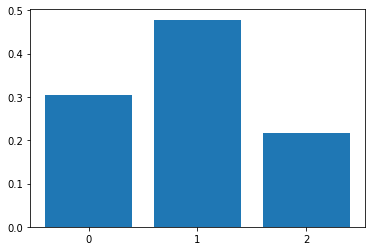

In [129]:
from random import random
import matplotlib.pyplot as plt


#Datos aleatorios para el ejemplo
m = estimar_marginal(df_train,'B',1)

def generate_histogram(df):
    variables = []
    for i in df:
        variables.append(i)
    var = variables[0]
   
    x = []
    y = []
    
    for i in df.index:

        x.append(str(df[var][i]))
        y.append(df['P'][i])
    
    fig, ax = plt.subplots()
    ax.bar(x,y)
    plt.show()
    
generate_histogram(m)



# Razonamiento basado en incerteza


Este proyecto tiene como objetivo buscar la mejor estructura que modele los datos de una base de datos, que se usará posteriormente para realizar inferencias.

Comenzaremos cargando la base de datos de estudio que también es llamada base de datos de entrenamiento.

In [80]:
df_train = leer_dataset("data.csv")
df_train

,A,B,C,D,E,F,G
0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,1
2,0,1,1,1,0,1,1
3,1,0,2,1,0,1,1
4,0,0,2,1,1,2,0
5,0,1,1,1,1,3,0
6,1,1,1,0,1,4,1
7,0,1,0,0,1,5,0
8,0,1,3,0,0,5,0
9,1,2,3,0,0,5,1


Observamos que se tienen 7 variables. Ahora estableceremos una hipotesis de cómo están relacionadas estas variables. La hipotesis se modelará como un DAG (directed aciclyc graph) donde un vertice representa una variable  y una arista (v1,v2) representa que la variable v2 depende de la variable v1.

Procederemos a cargar este grafo desde un archivo de texto y lo visualizaremos.


In [81]:
test_graph = {'A':['B'] ,'B':['D'],'C':['D'],'D':['F','G'], 'E': ['C'],'F':['G'], 'G':[] }  ##read_graph("graph.txt")

Este estudio está basado en redes bayesianas y se calcula las probabilidades usando el parametro de Dirichlet escrito normalmente como alpha

In [82]:
alpha = 1.0 #SET ALPHA

Antes de continuar se realizará un preprocesamiento de los datos. Esto mejora el tiempo de respuesta al calcular las metricas de calidad de 

A continuación se mostrará los factores de la red bayesiana

In [83]:
red = Red_Bayesiana(df = df_train, grafo = test_graph, alpha=alpha )
red.printFactores()

Factores del grafo
P(A) P(B|A) P(D|B,C) P(C|E) P(F|D) P(G|D,F) P(E) 

A continuación se muestra el histograma de probabilidades para cada variable.

Variable  A


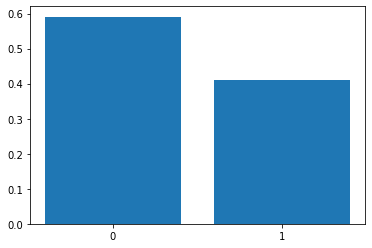

Variable  B


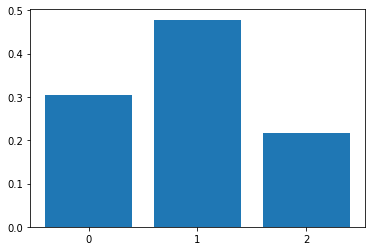

Variable  C


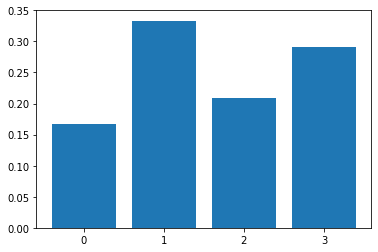

Variable  D


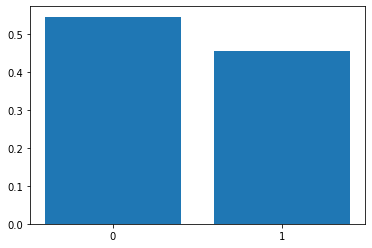

Variable  E


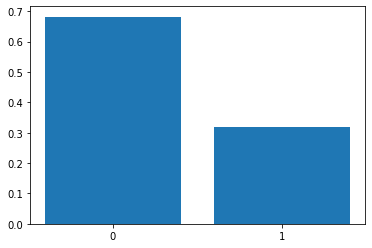

Variable  F


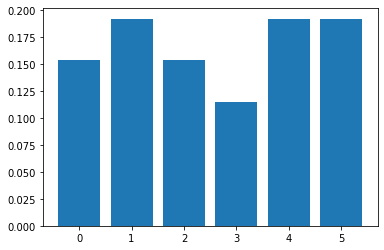

Variable  G


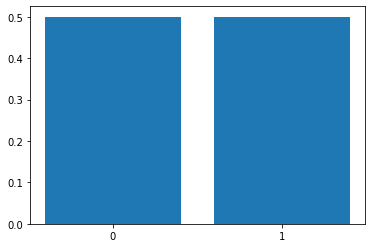

In [130]:
for var in df_train:
    print("Variable ",var)
    marginal = estimar_marginal(df_train,var, alpha)
    generate_histogram(marginal)

Ahora veremos la distribución conjunta de todas las variables del dataset

In [102]:
estimar_conjunta(df_train, ['A','B','C','D','E','F'], alpha=alpha)

,A,B,C,D,E,F,P
0,0,0,0,0,0,0,0.003356
1,1,0,0,0,0,0,0.001678
2,0,1,0,0,0,0,0.001678
3,1,1,0,0,0,0,0.001678
4,0,2,0,0,0,0,0.001678
...,...,...,...,...,...,...,...
571,1,0,3,1,1,5,0.001678
572,0,1,3,1,1,5,0.001678
573,1,1,3,1,1,5,0.001678
574,0,2,3,1,1,5,0.001678


## Inferencia

Hay 2 tipos de consultas de inferencia. La primera es teniendo las variables evidencia y consulta. Mientras que la segunda es cuando las variables evidencia no cubren todas las variables restantes, a las variables que no están en la evidencia y la consulta se les denomina variables aculta.

### Inferencia con evidencia y consulta

Aqui se calcula la probabilidad de la variable consulta a partir de la evidencia

Como ejemplo, sumpongamos que queremos consultar la variable G sabiendo que tenemos como evidencia a:

A = 1, B = 1, C = 2, D = 0, E = 1, F = 3

Con esta información veamos la probabilidad de G para cada uno de sus valores.

In [86]:
inferencia('G',['A','B','C','D','E','F'],[1,1,2,0,1,3], df_train, red)

,G,P
0,0,0.000557
1,1,0.000278


Observamos que P(G=1) es el mayor valor por lo que tiene mayor probabilidad de ser correcto.

### Inferencia con variables ocultas

Aqui se calcula la probabilidad de la variable consulta a partir de la evidencia y las variables ocultas

Como ejemplo, sumpongamos que queremos consultar la variable G sabiendo que tenemos como evidencia a:

A = 1, B = 1, C = 2

Entonces las variables ocultas serian:

D, E y F.


In [87]:
inferencia_con_variables_ocultas('G', ['A','B','C'],[1,1,2], red)

,G,P
0,0,0.023755
1,1,0.024254


En este caso también observamos que P(G=1) aunque con menor intensidad que el caso anterior.

## Busqueda de la mejor estructura

Esta sección tiene como objetivo buscar la estructura (DAG) que mejor se adapte a los datos que tenemos. Esta busqueda se realizará con 2 algoritmos: greedy search y k2 algorithm. Estos algoritmos usan metricas de calidad para comparar 2 estructuras diferentes. A continuación veremos las 4 métricas implementadas.

Antes de proceder con las métricas, se realizará un preprocesamiento para mejorar el tiempo de respuesta en el calculo de métricas de calidad, en consecuencia también se mejorará el tiempo de respuesta en los algoritmos de busqueda.




### Preprocesamiento

Se calcula las probabilidades conjuntas de cada par de variables, tambien las probabilidades marginales para cada variable y las probabilidades condicionales para cada par de variables. Y también vamos a convertir el grafo en una estrucura que es una clase que contiene más funciones como añadir vertices, eliminar vertices, etc.


In [88]:
preprocessor = Preprocessor(df=df_train, alpha=alpha)
test_graph = Estructure(test_graph, preprocessor=preprocessor)

### Métrica de entropía

In [89]:
get_entropia(test_graph)

193.63578309212014

### Métrica de akaike

In [90]:
get_akaike(test_graph)

239.63578309212014

### Métrica de MDL

In [91]:
get_mdl(test_graph)

293.0401292745295

### Métrica K2

In [92]:
get_k2(test_graph)

1.13953991731984e-53

 Exploraremos el 25 % del espacio total que es aproximadamente (2^7(6)).25%

In [ ]:
initial_graph = {'A':[],'B': [], 'C':[], 'D':[],'E':[],'F':[],'G':[]}
initial_graph = Estructure(initial_graph, preprocessor)

greedy_algorithm_search_space(initial_graph, get_akaike)

Ahora pongamos en acción los algoritmos de busqueda de la mejo0r estructura

### Greedy Search

In [98]:
initial_graph = {'A':[],'B': [], 'C':[], 'D':[],'E':[],'F':[],'G':[]}
initial_graph = Estructure(initial_graph, preprocessor)

nuevo_grafo = greedy_local_search_modified(initial_graph, get_akaike)
print("La mejor solución es :")
print(nuevo_grafo[0].estructura)
print("Se generaron: ",nuevo_grafo[1])

La mejor solución es :
{'A': [], 'B': [], 'C': ['F'], 'D': ['A', 'E'], 'E': [], 'F': [], 'G': ['F']}
Se generaron:  18


### Algoritmo K2

In [93]:

initial_graph = {'A':[],'B': [], 'C':[], 'D':[],'E':[],'F':[],'G':[]}
initial_graph = Estructure(initial_graph, preprocessor)

nuevo_grafo = k2_algorithm(initial_graph, get_akaike, 1)
print("La mejor solución es :")
print(nuevo_grafo.estructura)
    

La mejor solución es :
{'A': ['B', 'C'], 'B': [], 'C': ['D', 'E', 'F'], 'D': [], 'E': [], 'F': ['G'], 'G': []}
